# Applications of Deep Learning in Portfolio Optimisation for Asset Management
**Author:** Haochen Pan

**Date:** 20/04/2024

**Available at https://github.com/derek19990616/Applications_of_Deep_Learning_in_Portfolio_Optimisation_for_Asset_Management**

## Abstract
This study examines the application of deep learning models to enhance portfolio optimization in asset management. It focuses on the performance of Convolutional Neural Networks (CNNs), Temporal Convolutional Networks (TCNs), and Long Short-Term Memory networks (LSTMs) in forecasting asset price movements. Utilizing the Keras Python package, this research employs these models to ascertain the directional trends of daily asset returns as a basis for portfolio optimization. The evaluation includes an analysis of hyperparameter tuning to establish the most effective model configurations for training.

A key feature of this investigation is the employment of an ensemble approach, blending the predictive capabilities of CNNs, TCNs, and LSTMs, aiming to refine accuracy and reduce computational efforts. The ensemble model's forecasts serve as the foundation for a dynamic asset allocation strategy, which proposes adjustments to the portfolio in alignment with anticipated market movements. This strategy is geared towards informing whether to adopt long or short positions, with the ultimate aim of achieving optimal portfolio performance.

By mapping out the potential of deep learning models to improve asset management practices, this paper underscores their role in guiding strategic decisions related to asset allocation and portfolio optimization. The results are intended to illuminate how modeling techniques can be utilized for effective asset distribution, offering pragmatic insights for asset managers keen on integrating predictive analytics into their decision-making processes, especially in the context of portfolio optimization.

## Imports, Configurations & Random Seeds



In order to view and explore the data, we initially import several Python packages. Additionally, to allow readers to reproduce our results, we arbitrarily set several random seeds to 100. By setting fixed random seeds, we aim to minimize the uncertainty introduced by randomness, ensuring consistency and verifiability of the experiments.


In [1]:
# Import essential libraries for mathematical operations, data manipulation, and datetime handling.
import math
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

# Set matplotlib styles for plotting
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Disable logging for matplotlib font manager to avoid clutter
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# Configure display settings for pandas and numpy
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
%config InlineBackend.figure_format = 'svg'


In [ ]:
# Install additional Python packages needed for analysis 
!pip install keras-tcn


In [ ]:
# Install additional Python packages needed for quantitative statistics
!pip install quantstats

In [3]:
import tensorflow as tf
import random as rn

# Set seed value
seed = 100
# Set numpy random seed
np.random.seed(seed)
# Set random random seed
rn.seed(seed)
# Set tensorflow random seed
tf.random.set_seed(seed)

We retrieved data for selected tickers from Yahoo Finance and stored it in a CSV file. We constructed a portfolio using the 'Magnificent Seven' stocks—Nvidia, Meta, Amazon, Microsoft, Alphabet, Apple, and Tesla. Each of these stocks performed exceptionally well in 2023, significantly contributing to the broader market's gains. Initially, we saved the data to 'stock_data.csv'. To streamline the process, we now directly retrieve the data from this file, and the initial retrieval code has been commented out for clarity.


In [ ]:
"""
# Historical Stock Data Retrieval
# This script uses the yfinance library to download historical adjusted close prices for selected stocks from Yahoo Finance.
import yfinance as yf
import pandas as pd

# Define the tickers for the 'Magnificent Seven' stocks
tickers = ['MSFT', 'NVDA', 'AAPL', 'META', 'AMZN', 'GOOGL', 'TSLA']

# Download historical data from the start of 2020 to January 11, 2024
raw = yf.download(tickers, start='2020-01-01', end='2024-01-11')['Adj Close']

# Save the data to an HDF5 file
raw.to_hdf('stock_data.h5', key='df', mode='w')

# Read the data from the HDF5 file
raw = pd.read_hdf('stock_data.h5', key='df')

# Display the first few rows to ensure it is read correctly
print("Data from HDF5 (head):")
print(raw.head())
"""

In [10]:
import pandas as pd
import requests

# List of tickers for the 'Magnificent Seven' stocks
tickers = ['MSFT', 'NVDA', 'AAPL', 'META', 'AMZN', 'GOOGL', 'TSLA']

# URL to the HDF5 file hosted on GitHub
url = 'https://github.com/derek19990616/Applications_of_Deep_Learning_in_Portfolio_Optimisation_for_Asset_Management/raw/main/stock_data.h5'

# Fetch the file content from the URL
response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses

# Save the file content to a temporary file
with open('temp_stock_data.h5', 'wb') as file:
    file.write(response.content)

# Read the data from the temporary HDF5 file
raw = pd.read_hdf('temp_stock_data.h5', key='df')

# Display the first few rows of the DataFrame to ensure it is read correctly
print("Data from HDF5 (head):")
print(raw.head())

# Check data types to ensure they are numeric
print("Data types of the DataFrame:")
print(raw.dtypes)

Data from HDF5 (head):
Ticker        AAPL    AMZN   GOOGL     META     MSFT   NVDA    TSLA
Date                                                               
2020-01-02 73.0594 94.9005 68.3555 209.3498 154.4939 5.9736 28.6840
2020-01-03 72.3491 93.7485 67.9980 208.2421 152.5701 5.8780 29.5340
2020-01-06 72.9256 95.1440 69.8104 212.1640 152.9645 5.9027 30.1027
2020-01-07 72.5826 95.3430 69.6755 212.6231 151.5698 5.9741 31.2707
2020-01-08 73.7502 94.5985 70.1715 214.7786 153.9840 5.9853 32.8093
Data types of the DataFrame:
Ticker
AAPL     float64
AMZN     float64
GOOGL    float64
META     float64
MSFT     float64
NVDA     float64
TSLA     float64
dtype: object


In [11]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1013 entries, 2020-01-02 to 2024-01-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1013 non-null   float64
 1   AMZN    1013 non-null   float64
 2   GOOGL   1013 non-null   float64
 3   META    1013 non-null   float64
 4   MSFT    1013 non-null   float64
 5   NVDA    1013 non-null   float64
 6   TSLA    1013 non-null   float64
dtypes: float64(7)
memory usage: 63.3 KB


Next, we explore the price evolution of the seven tickers over the specified time period by plotting the data from the last column. It is evident that, between 2020 and 2024, the stocks show a significant divergence. In 2024, Nvidia and Meta have continued to rise sharply, while Tesla has become the most significant decliner so far this year on the S&P 500.



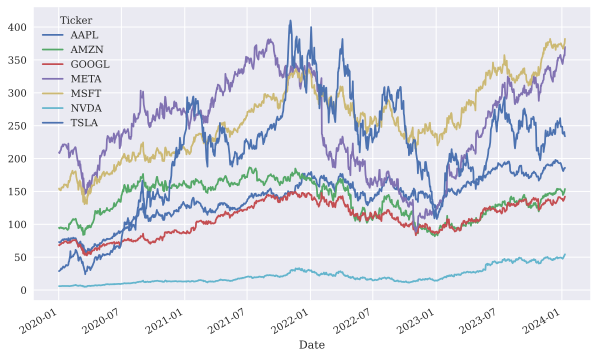

In [12]:
raw.plot(figsize=(10, 6));

In [13]:
# Calculate the logarithmic returns by taking the log of price ratios between consecutive days
data = np.log(raw / raw.shift(1))

# Delete data rows with nan values
data.dropna(inplace=True)
data.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2020-01-03,-0.0098,-0.0122,-0.0052,-0.0053,-0.0125,-0.0161,0.0292
2020-01-06,0.0079,0.0148,0.0263,0.0187,0.0026,0.0042,0.0191
2020-01-07,-0.0047,0.0021,-0.0019,0.0022,-0.0092,0.0120,0.0381
2020-01-08,0.0160,-0.0078,0.0071,0.0101,0.0158,0.0019,0.0480
2020-01-09,0.0210,0.0048,0.0104,0.0142,0.0124,0.0109,-0.0222


To inspect the distribution of the log returns, 
𝑟, we utilize the scipy package. Below, we plot the frequency distribution of the log returns, 
𝑟, alongside a normal distribution for comparison.

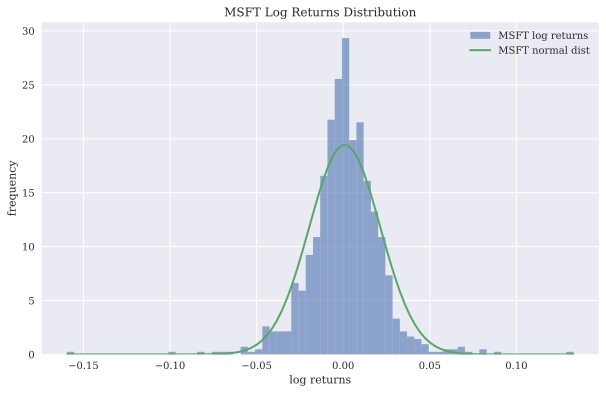

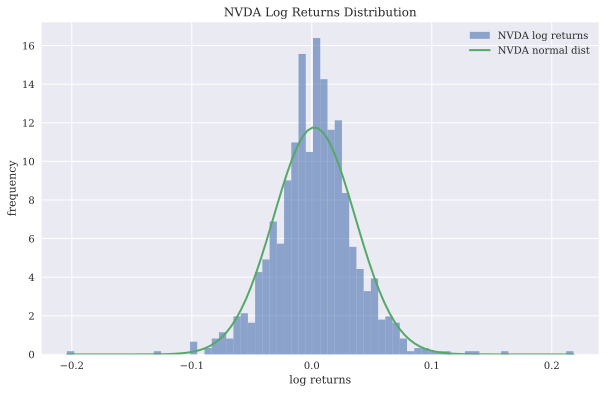

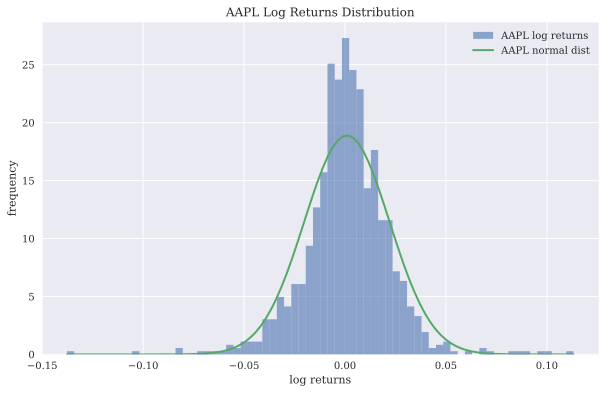

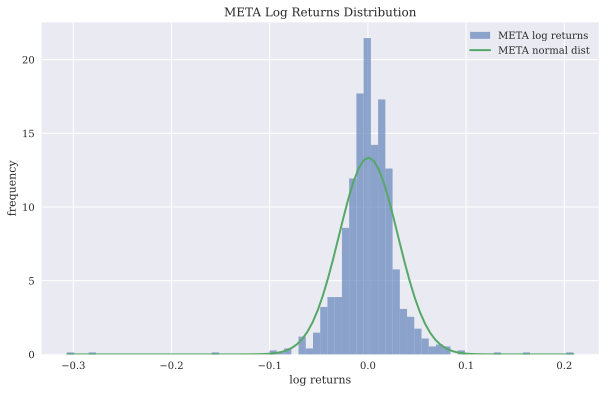

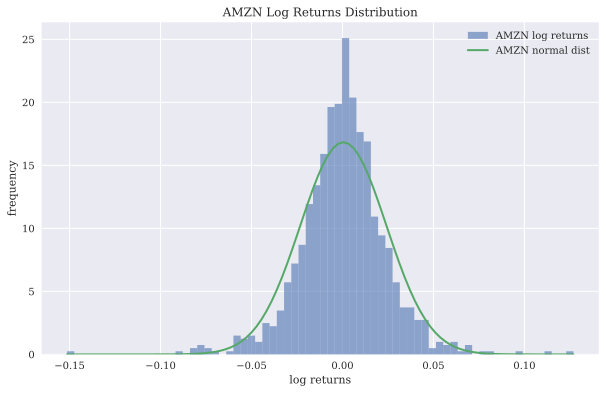

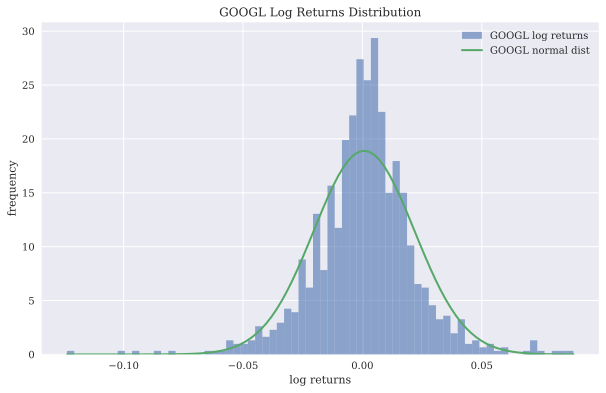

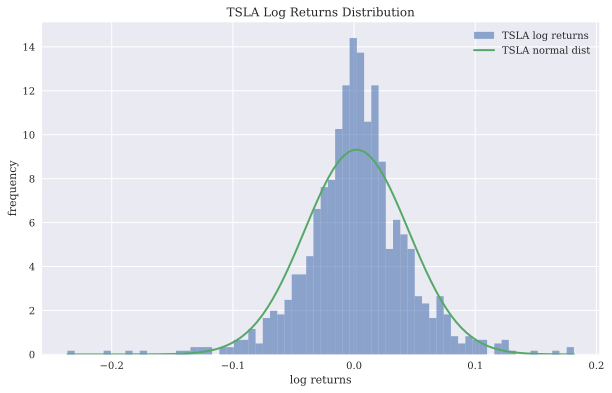

In [14]:
import scipy.stats as scs


# Loop through each ticker to create and plot their distributions separately
for ticker in tickers:
    # Set up the figure for plotting each ticker individually
    plt.figure(figsize=(10, 6))
    
    # Select the log returns for the current ticker
    ticker_rets = data[ticker]
    
    # Plot histogram for the ticker
    plt.hist(ticker_rets, bins=70, density=True, alpha=0.6, label=f'{ticker} log returns')
    
    # Fit a normal distribution to the ticker's log returns
    x = np.linspace(min(ticker_rets), max(ticker_rets), 100)
    plt.plot(x, scs.norm.pdf(x, ticker_rets.mean(), ticker_rets.std()), lw=2.0, label=f'{ticker} normal dist')
    
    # Name x axis
    plt.xlabel('log returns')
    
    # Name y axis
    plt.ylabel('frequency')
    
    # Add title with the ticker name
    plt.title(f'{ticker} Log Returns Distribution')
    
    # Display legend
    plt.legend()
    
    # Show the plot for this ticker
    plt.show()


### MSFT (Microsoft Corporation)
The histogram suggests a concentration of log returns around zero with a slight right skew.

### NVDA (NVIDIA Corporation)
This histogram also clusters around zero but with evidence of a sharper peak and potential fat tails, indicating a leptokurtic distribution.

### AAPL (Apple Inc.)
Similar to MSFT, this histogram shows a unimodal distribution with a modest skew to the right.

### META (Meta Platforms, Inc.)
The histogram shows a wide spread of returns, again with a peak near zero and a slight positive skew.

### AMZN (Amazon.com, Inc.)
This asset’s returns are tightly clustered, with a notable peak indicating higher frequency of smaller magnitude returns.

### GOOGL (Alphabet Inc.)
The distribution of returns shows a central peak, with log returns symmetrically distributed about the mean.

### TSLA (Tesla, Inc.)
The histogram for Tesla's log returns displays a pronounced peak and suggests a leptokurtic distribution with possible outliers or extreme values.

To investigate further, we use the statsmodels package to create a Q-Q plot of the log returns, r.



In [ ]:
import statsmodels.api as sm
for ticker in tickers:
    # Create Q-Q plot for the ticker
    sm.qqplot(data[ticker], line='s')
    
    # Add title with the ticker name
    plt.title(f'{ticker} Q-Q plot')
    
    # Name x axis
    plt.xlabel('theoretical quantiles')
    
    # Name y axis
    plt.ylabel('sample quantiles')
    
    # Show the plot
    plt.show()


We first extract the relevant dates from our dataset to match the predictions made by the model. These dates are then used to index a new DataFrame, which we populate with the predicted return values for each ticker. This approach results in a structured presentation of the predictions, enabling us to easily review the financial returns predicted by the model for each asset by date.

In [15]:

# Define the number of lags (past periods) to create
lags = 3

# Function to create lagged features for each column in a DataFrame
def create_lags(rets):
    cols = []  # Initialize a list to store the names of the new lag columns
    
    # Iterate over each column in the DataFrame
    for sym in rets.columns:
        # For each column, generate up to 'lags' lagged features
        for lag in range(1, lags + 1):
            # Create a new column name for each lag
            col = f'{sym}_lag_{lag}'
            # Shift the data in the column down by 'lag' places; this creates the lagged feature
            rets[col] = rets[sym].shift(lag)
            # Append the new column name to the list
            cols.append(col)
    # Return a list of all created column names
    return cols


In [16]:
cols = create_lags(data)

In [17]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1009 entries, 2020-01-08 to 2024-01-10
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AAPL         1009 non-null   float64
 1   AMZN         1009 non-null   float64
 2   GOOGL        1009 non-null   float64
 3   META         1009 non-null   float64
 4   MSFT         1009 non-null   float64
 5   NVDA         1009 non-null   float64
 6   TSLA         1009 non-null   float64
 7   AAPL_lag_1   1009 non-null   float64
 8   AAPL_lag_2   1009 non-null   float64
 9   AAPL_lag_3   1009 non-null   float64
 10  AMZN_lag_1   1009 non-null   float64
 11  AMZN_lag_2   1009 non-null   float64
 12  AMZN_lag_3   1009 non-null   float64
 13  GOOGL_lag_1  1009 non-null   float64
 14  GOOGL_lag_2  1009 non-null   float64
 15  GOOGL_lag_3  1009 non-null   float64
 16  META_lag_1   1009 non-null   float64
 17  META_lag_2   1009 non-null   float64
 18  META_lag_3   1009 non-null   f

In [18]:
# Normalize the specified columns in the DataFrame
# This operation standardizes each column to have a mean of 0 and a standard deviation of 1
data[cols] = (data[cols] - data[cols].mean()) / data[cols].std()

A critical part of any machine learning study is to have a clear distinction between the data that is used to train a model and the data used to evaluate the predictive power of the model out-of-sample. Therefore, we will split our data into three sections:

- **Train:** 80% of data will be used for training the models.
- **Val:** 15% of the training data will be used to validate the performance of the models during the training stages.
- **Test:** 20% of data will be used to evaluate the performance of the models out-of-sample.


In [19]:
# 80% train/test split
split = int(len(data) * 0.8)
# 15% validation partition
val_size = int(split * 0.15)
# Create train data set
train = data.iloc[:split]


We initially copy the first 80% of the dataset to form our preliminary training dataset.
- **Training Subset:** From this initial training subset, we extract the last 15% to form the validation set. This is crucial for tuning the model parameters during training.
- **Adjust Training Set:** After extracting the validation data, we adjust the training set to exclude the validation portion.
- **Test Dataset:** Finally, the remaining 20% of the original dataset is set aside as the test dataset. This portion is used to evaluate the model's performance on data it has never seen before, providing insights into the model's generalizability and out-of-sample predictive power.


In [20]:
# Train data prior to validation split
train = data.iloc[:split].copy()
# Validation data
val = train[-val_size:]
# Train data after validation split
train = train[:-val_size]
# Test data
test = data.iloc[split:].copy()

We reshape the training, validation, and test datasets (X_train, X_val, X_test) to match the input structure required by our neural networks, ensuring each set has dimensions suitable for model processing. This reshaping facilitates the handling of feature sets within the network layers, allowing the neural network to effectively process and learn from the data:
- **X_train**: Reshaped to meet the input specifications of the training phase.
- **X_val**: Adjusted to fit the validation process, aiding in tuning the network's parameters.
- **X_test**: Configured to evaluate the model's performance on unseen data, testing its generalizability.


In [21]:
# Reshape training data to match the input structure required by the neural network
X_train = train[cols].values.reshape((-1, 1, len(cols)))

# Reshape validation data for compatibility with the network's input expectations during model tuning
X_val = val[cols].values.reshape((-1, 1, len(cols)))

# Reshape test data to conform to the required input dimensions for evaluating model generalizability
X_test = test[cols].values.reshape((-1, 1, len(cols)))

**Preparing Target Variables for Model Training and Evaluation:**

- **Training and Validation Targets:**
  For both the training and validation sets (`y_train` and `y_val`), we shift the data by one position to obtain future values as labels. This process involves removing the last entry as it lacks a subsequent value to serve as a label, ensuring each training and validation input has a corresponding target.

- **Testing Targets:**
  The test set (`y_test`) is similarly shifted to align future values as labels; however, we retain the last row. Retaining the last row is critical for assessing immediate prediction performance on this unseen data, providing a crucial test of the model's


In [22]:
# For the training data, we still need to remove the last row, as it does not have a future value to serve as a label
y_train = train[tickers].shift(-1)
y_val = val[tickers].shift(-1)
y_test = test[tickers].shift(-1)  

# Ensure that the target variables are also in the correct shape.
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values


In [23]:
# Calculate the mean of the training targets, ignoring NaN values
means = np.nanmean(y_train, axis=0)
# Replace NaN values in y_train with the calculated mean values
y_train = np.where(np.isnan(y_train), means, y_train)

# Calculate the mean of the revised y_train to use for filling y_val
y_train_means = np.nanmean(y_train, axis=0)
# Replace NaN values in y_val with the means from y_train
y_val = np.where(np.isnan(y_val), y_train_means, y_val)

# Calculate the mean for y_test, ignoring NaNs, for consistency
y_test_means = np.nanmean(y_test, axis=0)
# Replace NaN values in y_test with the calculated mean values
y_test = np.where(np.isnan(y_test), y_test_means, y_test)

# Output the shapes of the training, validation, and test datasets to verify dimensions
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# Check for any remaining NaN or infinite values across datasets to ensure data integrity
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())
print("NaN in X_test:", np.isnan(X_test).any())
print("Inf in X_test:", np.isinf(X_test).any())
print("NaN in y_test:", np.isnan(y_test).any())
print("Inf in y_test:", np.isinf(y_test).any())
print("NaN in X_val:", np.isnan(X_val).any())
print("Inf in X_val:", np.isinf(X_val).any())
print("NaN in y_val:", np.isnan(y_val).any())
print("Inf in y_val:", np.isinf(y_val).any())

Train shapes: (686, 1, 21) (686, 7)
Validation shapes: (121, 1, 21) (121, 7)
Test shapes: (202, 1, 21) (202, 7)
NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False
NaN in X_test: False
Inf in X_test: False
NaN in y_test: False
Inf in y_test: False
NaN in X_val: False
Inf in X_val: False
NaN in y_val: False
Inf in y_val: False


We created helper functions to calculate the portfolio variance and volatility:
- **Portfolio Variance**: This function calculates the variance of the portfolio based on the weights and returns of the assets. We scale the variance to an annual measure by multiplying it by 252, which represents the typical number of trading days in a year. This annualization helps in comparing the portfolio's risk over a standard period.

- **Portfolio Volatility**: This function computes the volatility, which is the square root of the variance. By understanding the volatility, investors can get a sense of the risk associated with the portfolio's returns in terms of standard deviation.


In [24]:
def portfolio_variance(weights, rets):
    """
    Calculate the annualized variance of a portfolio.

    Args:
        weights (numpy.array): Array of portfolio weights.
        rets (pandas.DataFrame): DataFrame containing returns of each asset.

    Returns:
        float: Annualized variance of the portfolio calculated using
               the dot product of weights, the covariance matrix of returns, 
               and the weights transposed, scaled by 252 trading days.
    """
    # Calculate covariance matrix from asset returns
    covariance_matrix = rets.cov()
    # Calculate the dot product of weights transposed and the covariance matrix
    weighted_covariance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    # Annualize the variance by the number of trading days
    annual_variance = weighted_covariance * 252
    return annual_variance

def portfolio_volatility(weights, rets):
    """
    Calculate the annualized volatility of a portfolio.

    Args:
        weights (numpy.array): Array of portfolio weights.
        rets (pandas.DataFrame): DataFrame containing returns of each asset.

    Returns:
        float: Annualized volatility of the portfolio, which is the square
               root of the annualized variance.
    """
    # Calculate annualized variance from the portfolio_variance function
    annual_variance = portfolio_variance(weights, rets)
    # Calculate the square root of the annual variance to get volatility
    annual_volatility = math.sqrt(annual_variance)
    return annual_volatility


## CNN Model Architecture and Training for Asset Return Prediction
This analysis utilizes an advanced Convolutional Neural Network (CNN) to forecast the return rates of various assets, employing the Keras library with TensorFlow as the backend. The approach adopts sophisticated deep learning techniques tailor-made for the complexities of quantitative finance.

### Model Building

#### Initialization
- **Sequential Model**: A Sequential model is initialized, facilitating a layer-by-layer assembly that provides a structured approach to incorporating convolutional, normalization, and dense layers.

#### Core Layers
- **Convolutional Layer**: The initial layer is a 1D convolutional layer, equipped with a designated number of filters and kernel size. It is designed to process temporal sequences by capturing features across the time dimension efficiently.
- **Batch Normalization**: Follows each convolutional deployment to standardize activations, thereby helping to stabilize and expedite the training phase.
- **Dropout**: Implemented conditionally to mitigate overfitting by randomly disabling a portion of the feature detectors during training.

#### Flattening and Dense Layers
- **Flattening**: Outputs from convolutional stages are flattened, transforming the 2D feature maps into a 1D vector that feeds into subsequent dense layers.
- **Dense Layers**: A dense layer featuring 50 neurons utilizes 'relu' activation to introduce non-linearity, culminating in a final output layer tailored to predict continuous asset returns without any activation function.

### Model Compilation and Optimization
- **Optimizer**: An Adam optimizer with a deliberately reduced learning rate is employed, allowing for meticulous adjustments aimed at minimizing the mean squared error (MSE).
- **Loss Function**: The MSE is selected to align the model’s training objectives with minimizing prediction errors for asset returns.

### Parameter Tuning and Model Training
- **Parameter Grid Search**: A comprehensive exploration across a predefined grid of hyperparameters (filters, kernel size, dropout rates, hidden layers) is conducted to identify the optimal settings. This procedure iterates over various combinations, evaluating each model configuration based on validation loss and accuracy.
- **Performance Monitoring**: The training is monitored using an EarlyStopping callback, which terminates the process when no further improvements in validation loss are observed, ensuring computational efficiency and preventing over-training.
- **Optimal Parameters Selection**: The selection of the best model parameters is determined by continuously comparing the current models against the best observed validation loss and accuracy. This ensures that the most effective model configuration is adopted.

### Evaluation and Practical Application
- **Predictive Performance**: Post-training, the model’s efficacy is assessed on a separate test set, initially inspecting a subset of predictions to verify operational accuracy.
- **Metrics Calculation**: Performance metrics such as MSE and accuracy for each asset are computed to quantitatively evaluate prediction accuracy.
- **Financial Metrics and Optimization**: Predictions from the model are subsequently utilized in financial scenarios like portfolio optimization, where constraints are applied to maximize financial returns based on predictive insights.

This detailed exposition underscores the utilization of CNNs in financial analytics, highlighting the sophisticated deep learning techniques and systematic parameter optimization approach employed to manage and predict complex financial time series data effectively.



In [25]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, accuracy_score

# Function to calculate custom accuracy based on a threshold
def reg_accuracy(y_true, y_pred, threshold=0.1):
    """
    Calculate a custom accuracy based on a threshold that defines how close 
    the predictions need to be to the actual values to be considered accurate.
    """
    return K.mean(K.less_equal(K.abs(y_true - y_pred), threshold), axis=-1)

# Function to build a CNN model with configurable parameters
def build_cnn(input_shape, filters, kernel_size, dropout_rate, hidden_layers, output_units=7):
    """
    Build a CNN model according to specified parameters.
    """
    model = Sequential(name='CNN_Model')
    # Add a convolutional layer with specified number of filters and kernel size
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                     input_shape=input_shape, padding='same'))
    # Normalize the activations of the previous layer
    model.add(BatchNormalization())
    # Optionally add dropout to reduce overfitting
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))

    # Add additional convolutional layers based on the number of hidden layers specified
    for _ in range(1, hidden_layers):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(rate=dropout_rate))

    # Flatten the output to make it suitable for input to a dense layer
    model.add(Flatten())
    # Add a fully connected layer with 50 neurons
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))
    # Output layer with a number of units equal to the number of output variables
    model.add(Dense(output_units, activation='linear'))

    # Define the optimizer with a specified learning rate, compile the model with MSE loss
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mean_squared_error', reg_accuracy])
    
    return model



In [26]:
import itertools
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

"""
# Hyperparameter tuning, finding the best parameter.

# Dictionary containing the parameter options for the CNN
param_grid = {
    'filters': [16, 32, 64, 128, 256],  # Number of filters in the conv layers
    'kernel_size': [2, 3],  # Size of the kernel to use in each conv layer
    'dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate to prevent overfitting
    'hidden_layers': [2, 3, 4]  # Number of hidden conv layers in the network
}

# Variables to store the best model, its loss, and parameters
best_model = None
best_loss = float('inf')
best_params = {}

# Iterates over every combination of parameters in the grid
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))  # Create a parameter dictionary
    print("Testing configuration:", param_dict)
    try:
        # Build CNN model with the current set of parameters
        cnn_model = build_cnn(input_shape=(1, len(tickers)*lags), output_units=len(tickers), **param_dict)
        
        # Setup early stopping to prevent overfitting
        early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
        
        # Fit the model
        cnn_model.fit(
            X_train, y_train, 
            epochs=1000,  # Large number of epochs, controlled by early stopping
            batch_size=32, 
            verbose=1, 
            validation_data=(X_val, y_val), 
            callbacks=[early_stopping_monitor]
        )
        val_loss = cnn_model.evaluate(X_val, y_val, verbose=0)[0]  # Evaluate the model on the validation set
        
        # Update the best model if the current model has a lower validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = cnn_model
            best_params = param_dict
            print(f"New best model found: {param_dict} with validation loss: {val_loss:.4f}")
    except Exception as e:
        print(f"Failed to build or train model with parameters {param_dict} due to error: {e}")

# Output the best model parameters and its validation loss
print(f"Best model parameters: {best_params} with validation loss: {best_loss:.4f}")
"""



'\n# Hyperparameter tuning, finding the best parameter.\n\n# Dictionary containing the parameter options for the CNN\nparam_grid = {\n    \'filters\': [16, 32, 64, 128, 256],  # Number of filters in the conv layers\n    \'kernel_size\': [2, 3],  # Size of the kernel to use in each conv layer\n    \'dropout_rate\': [0.2, 0.3, 0.4],  # Dropout rate to prevent overfitting\n    \'hidden_layers\': [2, 3, 4]  # Number of hidden conv layers in the network\n}\n\n# Variables to store the best model, its loss, and parameters\nbest_model = None\nbest_loss = float(\'inf\')\nbest_params = {}\n\n# Iterates over every combination of parameters in the grid\nfor params in itertools.product(*param_grid.values()):\n    param_dict = dict(zip(param_grid.keys(), params))  # Create a parameter dictionary\n    print("Testing configuration:", param_dict)\n    try:\n        # Build CNN model with the current set of parameters\n        cnn_model = build_cnn(input_shape=(1, len(tickers)*lags), output_units=len(ti

In [27]:
"""
cnn_model = build_cnn(
    input_shape=(1, len(tickers)*lags),
    output_units=len(tickers),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    hidden_layers=best_params['hidden_layers']
)
"""
# We use assigned parameters instead to save running time. Or unhide the above section and use the automated hyperparameter tuning part.
cnn_model = build_cnn(
    input_shape=(1, len(tickers)*lags),
    output_units=len(tickers),
    filters=16,
    kernel_size=3,
    dropout_rate=0.4,
    hidden_layers=4
) 

# Setup EarlyStopping monitor
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',  # The metric to monitor, here it is the validation set loss
    patience=10,         # Stop after 10 epochs with no improvement
    verbose=1,           # Log printing
    restore_best_weights=True  # Restore model weights from the epoch with the best monitored quantity
)

# Train the model using early stopping
cnn_model.fit(
    X_train, y_train,
    epochs=1000,  # A large number, but controlled by early stopping
    batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_monitor]  # Pass early stopping as a callback
)

# Evaluate the model
test_loss, test_mse, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/1000
22/22 [==============================] - 2s 18ms/step - loss: 3.1163 - mean_squared_error: 3.1163 - reg_accuracy: 0.0591 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_reg_accuracy: 0.8772
Epoch 2/1000
22/22 [==============================] - 0s 4ms/step - loss: 3.0553 - mean_squared_error: 3.0553 - reg_accuracy: 0.0562 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_reg_accuracy: 0.5183
Epoch 3/1000
22/22 [==============================] - 0s 4ms/step - loss: 2.8596 - mean_squared_error: 2.8596 - reg_accuracy: 0.0575 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_reg_accuracy: 0.2975
Epoch 4/1000
22/22 [==============================] - 0s 4ms/step - loss: 3.0069 - mean_squared_error: 3.0069 - reg_accuracy: 0.0564 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_reg_accuracy: 0.1877
Epoch 5/1000
22/22 [==============================] - 0s 5ms/step - loss: 2.6908 - mean_squared_error: 2.6908 - reg_accuracy: 0.0569 - val_loss: 0.0493

In [28]:
# Save the trained CNN model to an H5 file
cnn_model.save('best_cnn_model.h5')

# Predict using the saved CNN model on the test dataset
cnn_pred = cnn_model.predict(X_test)

# Display the first 5 predictions from the CNN model
print(cnn_pred[:5])

7/7 [==============================] - 0s 1ms/step
[[-0.0431 -0.0534  0.0555 -0.0599  0.0833  0.0493 -0.0432]
 [-0.0499 -0.0574  0.0421 -0.0808  0.0844  0.0351 -0.0745]
 [-0.0494 -0.058   0.0414 -0.0794  0.0814  0.031  -0.0762]
 [-0.0374 -0.0459  0.0442 -0.0553  0.0864  0.0447 -0.0634]
 [-0.0453 -0.0575  0.0435 -0.0798  0.0803  0.0394 -0.0613]]


We handle the preparation, training, and prediction stages of our CNN model to forecast financial returns. Here's a detailed overview of the process:

- **Data Preparation**:
  - **Reshaping the Feature Set**: Initially, we adjust the feature set to match the input requirements of our CNN model.
  - **Data Splitting**: We divide the data into training, validation, and test sets. This segmentation allows us to train the model effectively and evaluate its performance on unseen data.

- **Model Training**:
  - **Training Setup**: Using the specified hyperparameters, the model is trained on the training set. This phase includes optimizing weights and biases to minimize errors.
  - **Validation**: During training, the model is also validated using a separate validation set. This helps us monitor the model's performance and prevent overfitting.

- **Prediction and Evaluation**:
  - **Testing on Unseen Data**: After training, the model is used to predict future returns using the test set. These are data points that the model has not seen during the training or validation phases.
  - **Effectiveness Validation**: The results from the test set are used to validate the model’s effectiveness in predicting financial metrics based on historical data.

This structured approach ensures that each phase of the model lifecycle is carefully managed to optimize performance and accuracy in financial return forecasting.


In [29]:
# Associate the predictions with their corresponding dates
prediction_dates = data.index[-len(cnn_pred):]  # Get the dates for the predictions from the dataset
predicted_returns = pd.DataFrame(cnn_pred, index=prediction_dates, columns=tickers)

# Display the first 5 rows of the predicted returns to verify the output
predicted_returns.head()

,MSFT,NVDA,AAPL,META,AMZN,GOOGL,TSLA
Date,,,,,,,
2023-03-23,-0.0431,-0.0534,0.0555,-0.0599,0.0833,0.0493,-0.0432
2023-03-24,-0.0499,-0.0574,0.0421,-0.0808,0.0844,0.0351,-0.0745
2023-03-27,-0.0494,-0.0580,0.0414,-0.0794,0.0814,0.0310,-0.0762
2023-03-28,-0.0374,-0.0459,0.0442,-0.0553,0.0864,0.0447,-0.0634
2023-03-29,-0.0453,-0.0575,0.0435,-0.0798,0.0803,0.0394,-0.0613


In [30]:
predicted_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 202 entries, 2023-03-23 to 2024-01-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    202 non-null    float32
 1   NVDA    202 non-null    float32
 2   AAPL    202 non-null    float32
 3   META    202 non-null    float32
 4   AMZN    202 non-null    float32
 5   GOOGL   202 non-null    float32
 6   TSLA    202 non-null    float32
dtypes: float32(7)
memory usage: 7.1 KB


In [31]:
# Extract the actual returns corresponding to the dates of the predicted returns
true_returns = data.loc[predicted_returns.index, tickers]

# Calculate the MSE between the actual returns and the predicted returns
mse = mean_squared_error(true_returns, predicted_returns)

# Print the calculated MSE to check the model's accuracy
print(f"Mean Squared Error (MSE) of the portfolio: {mse:.4f}")


Mean Squared Error (MSE) of the portfolio: 0.0042


In [32]:
# Iterate through each ticker to calculate and print the MSE
for ticker in tickers:
    # Calculate the MSE between the actual and predicted returns for each ticker
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    # Print the MSE for each ticker formatted to display with clarity
    print(f'{ticker}: MSE={mse:.4f}')


MSFT: MSE=0.0023
NVDA: MSE=0.0037
AAPL: MSE=0.0018
META: MSE=0.0065
AMZN: MSE=0.0072
GOOGL: MSE=0.0016
TSLA: MSE=0.0063


In [33]:
# Iterate through each ticker to calculate and print the accuracy of predictions
for ticker in tickers:
    # Calculate the accuracy based on the sign of the returns
    acc = accuracy_score(
        np.sign(true_returns[ticker]),  # Actual returns sign
        np.sign(predicted_returns[ticker])  # Predicted returns sign
    )
    # Print the accuracy for each ticker
    print(f'{ticker}: Accuracy={acc:.4f}')

MSFT: Accuracy=0.4406
NVDA: Accuracy=0.4455
AAPL: Accuracy=0.5347
META: Accuracy=0.4505
AMZN: Accuracy=0.5495
GOOGL: Accuracy=0.5396
TSLA: Accuracy=0.4802


In [34]:
# Create a strategy DataFrame where the strategy returns are calculated by multiplying
# the sign of the predicted returns by the actual returns
strat_cnn = np.sign(predicted_returns) * true_returns[tickers]

# Display the first 5 rows of the strategy DataFrame to verify the calculations
strat_cnn.head()

,MSFT,NVDA,AAPL,META,AMZN,GOOGL,TSLA
Date,,,,,,,
2023-03-23,-0.0195,-0.0269,0.0069,-0.0221,0.0001,0.0213,-0.0056
2023-03-24,-0.0104,0.0153,0.0083,-0.0084,-0.0059,-0.0015,0.0095
2023-03-27,0.0150,0.0093,-0.0124,0.0155,-0.0009,-0.0287,-0.0073
2023-03-28,0.0042,0.0046,-0.0040,0.0107,-0.0082,-0.0141,0.0138
2023-03-29,-0.0190,-0.0215,0.0196,-0.0230,0.0305,0.0036,-0.0245


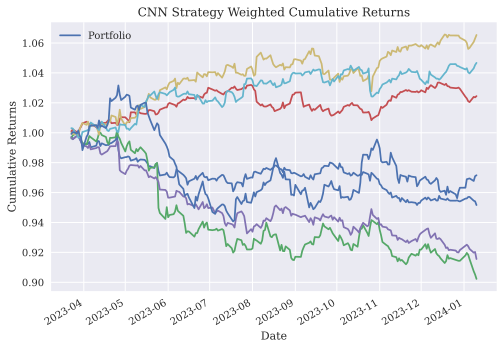

In [35]:
# Define equal weights for each ticker
weights = np.full(len(tickers), 1 / len(tickers))

# Calculate the weighted returns, compute the cumulative sum, and apply the exponential function
weighted_cumulative_returns = (strat_cnn * weights).cumsum().apply(np.exp)

# Plot the weighted cumulative returns
weighted_cumulative_returns.plot()

# Add labels and title to the plot for better readability
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('CNN Strategy Weighted Cumulative Returns')
plt.legend(['Portfolio'])

# Display the plot
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2023-03-23
End Period                 2024-01-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -13.19%
CAGR﹪                     -11.45%

Sharpe                     -1.51
Prob. Sharpe Ratio         8.33%
Smart Sharpe               -1.35
Sortino                    -1.92
Smart Sortino              -1.72
Sortino/√2                 -1.36
Smart Sortino/√2           -1.22
Omega                      0.78

Max Drawdown               -16.75%
Longest DD Days            260
Volatility (ann.)          11.27%
Calmar                     -0.68
Skew                       -0.6
Kurtosis                   3.59

Expected Daily %           -0.07%
Expected Monthly %         -1.28%
Expected Yearly %          -6.83%
Kelly Criterion            -13.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.24%
Expected Shortfall (cVaR)  -1.24%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-04-26,2023-07-18,2024-01-10,260,-16.7486,-15.7519
2,2023-03-27,2023-03-31,2023-04-04,9,-1.6259,-0.8707
3,2023-04-17,2023-04-18,2023-04-19,3,-0.8054,-0.5998
4,2023-04-10,2023-04-11,2023-04-12,3,-0.6679,-0.5208


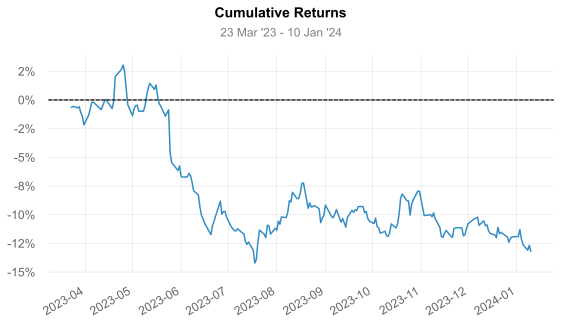

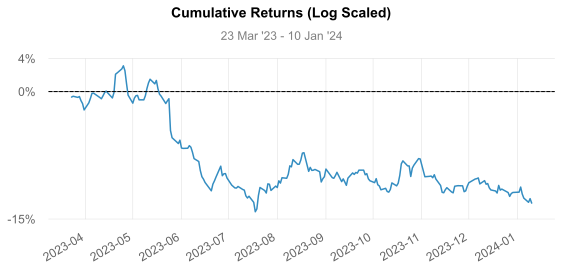

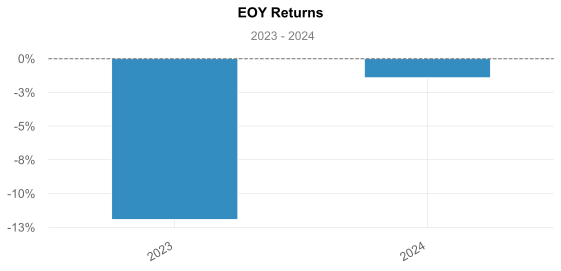

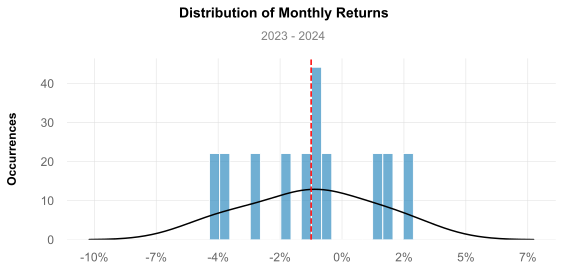

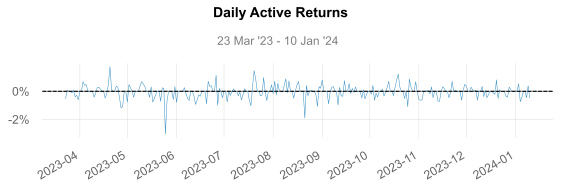

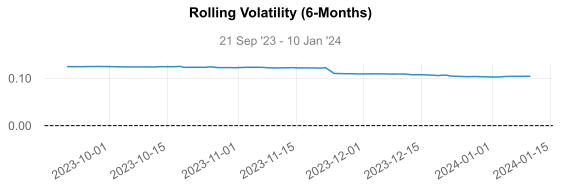

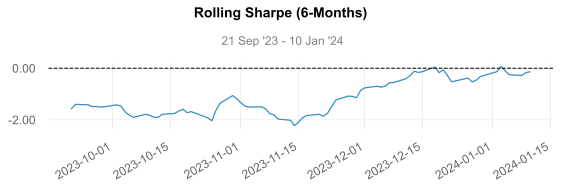

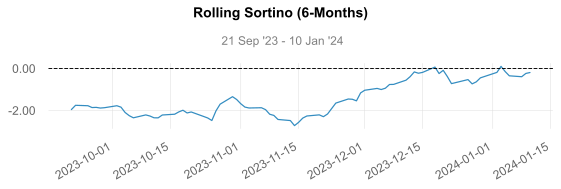

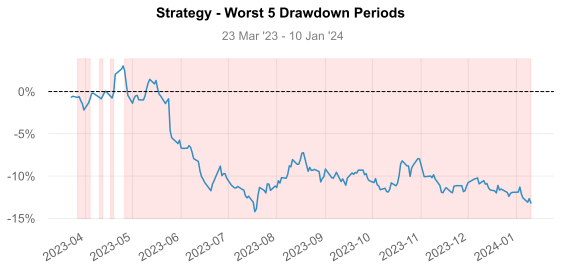

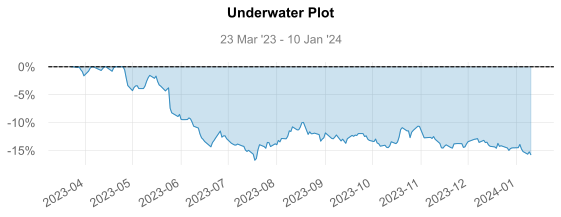

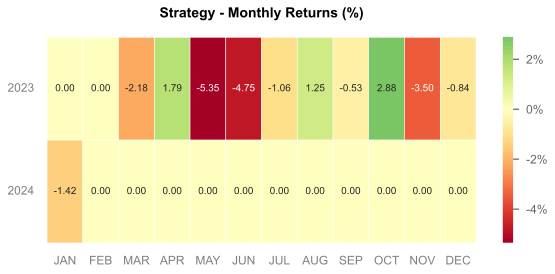

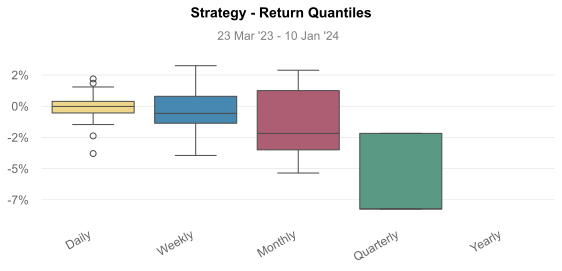

In [36]:
# Display the performance through Quantstats
import quantstats as qs

# Calculate cumulative returns for the CNN strategy
cnn_portfolio_cumulative_returns = (strat_cnn * weights).sum(axis=1)

# Ensure no NaN values in daily returns
cnn_daily_returns = cnn_portfolio_cumulative_returns.fillna(0)

# Generate a performance tear sheet using Quantstats
qs.extend_pandas()
qs.reports.full(cnn_daily_returns)



## CNN Model Performance Analysis

The CNN model's weighted-average performance over the observed period shows a cumulative negative return, indicating an overall loss in the strategy. Key metrics highlight the following insights:

- **Negative Sharpe Ratio**: The strategy has a negative Sharpe ratio, suggesting that its risk-adjusted return underperforms the risk-free rate.
- **Significant Maximum Drawdown and Volatility**: The strategy experienced substantial drawdowns and high volatility, reflecting a higher risk profile.
- **Mixed Monthly and Quarterly Win Rates**: The win rates for both monthly and quarterly periods are inconsistent, with periods of gains often overshadowed by periods of losses.

### Detailed Observations:
- **Cumulative Returns**: The predominantly downward trend in cumulative returns indicates the strategy's difficulty in delivering consistent positive returns.
- **Distribution of Monthly Returns**: The variability in monthly returns further demonstrates the inconsistency in performance.

Overall, the strategy faced significant challenges in achieving consistent profitability, as evidenced by the key performance metrics and the overall trend of the cumulative returns.





In [ ]:
from scipy.optimize import minimize

# Define bounds for each ticker
bnds = len(tickers) * [(-1, 1)]

# Define the constraint that the sum of weights must be equal to 1
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}


In [ ]:
# ensure weight has the same data structure
w_cnn = predicted_returns.copy()

In [ ]:
# Define the Sharpe ratio function
def sharpe(weights, r, re):
    """
    Calculate the Sharpe ratio of a portfolio.
    
    Args:
        weights (array): Array of portfolio weights.
        r (array): Expected returns for each asset.
        re (DataFrame): DataFrame containing returns for each asset.
    
    Returns:
        float: The Sharpe ratio of the portfolio.
    """
    port_ret = np.dot(r, weights)
    port_vol = portfolio_volatility(weights, re)
    return port_ret / port_vol


In [ ]:
%%time
for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0], tickers]
    opt = minimize(
        lambda w_cnn: -sharpe(w_cnn, r=r, re=re),
        np.ones(len(tickers)),
        bounds=bnds,
        constraints=cons
    )
    w_cnn.loc[pred[0]] = opt['x']

opt['x']


In [ ]:
# Optimized weighted portfolio
strat_cnn_optimum = w_cnn * true_returns.loc[w_cnn.index[0]:, tickers]
strat_cnn_optimum.dropna(inplace=True)

# Plot the cumulative sum of the optimized strategy returns
strat_cnn_optimum.cumsum().apply(np.exp).plot()


In [ ]:
# Calculate the sum of optimal strategy returns for each day
strat_cnn_optimum_print = strat_cnn_optimum.sum(axis=1)

# Fill any missing values with 0 to ensure continuity
cnn_optimum_daily_returns = strat_cnn_optimum_print.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(cnn_optimum_daily_returns)


## CNN Model Performance Analysis

### Pre-Optimization

The CNN model's performance prior to optimization shows a fluctuating yet overall declining trajectory in the cumulative returns plot. This results in negative performance with a significant drawdown, as evidenced by the performance metrics displaying a negative cumulative return and a Sharpe ratio far below zero.

### Post-Optimization

After the optimization of weights, the CNN model exhibits a starkly improved performance. The cumulative returns plot now indicates a growth trajectory, and the performance metrics show a positive cumulative return with an enhanced Sharpe ratio above zero. 

### Conclusion

This comparison suggests that the optimization process contributed significantly to the strategy's effectiveness, successfully transforming a strategy with suboptimal returns into one with a profitable outcome.


## LSTM Model Architecture and Training for Asset Return Forecasting

This comprehensive analysis utilizes a Long Short-Term Memory (LSTM) network to predict the return rates of various financial assets, employing the Keras library with TensorFlow as the backend. This strategy highlights the use of LSTM, renowned for its efficacy in capturing temporal dependencies in time series data, thus making it particularly suited for financial applications.

### Model Construction

#### Initialization
- **Sequential Model**: A Sequential model structure is employed, facilitating a systematic assembly of layers. This methodical layer-by-layer construction allows for a clear and logical addition of LSTM, dropout, and dense layers.

#### Core Configuration
- **LSTM Layers**: Multiple LSTM layers are configured, where each layer is tailored based on the specified number of units and layers. The first LSTM layer explicitly defines the input shape and returns sequences if additional layers are present, allowing for the propagation of temporal information.
- **Dropout Layers**: Conditionally added between LSTM layers to prevent overfitting by randomly omitting units during training, thereby enhancing the model's generalization ability.

#### Output Specification
- **Dense Output Layer**: Concludes with a dense output layer using a linear activation function to predict continuous returns directly, aligning with the regression nature of the task.

### Model Compilation and Optimization

#### Compiling the Model
- **Optimizer**: The model is compiled using the 'adam' optimizer, renowned for its efficiency in handling sparse gradients on noisy problems.
- **Loss Function**: The mean squared error (MSE) serves as the loss function, directly aligning with the objective to minimize prediction errors for asset returns.
- **Custom Metrics**: A bespoke accuracy metric, `reg_accuracy`, is defined to assess predictions within a specified threshold, providing a nuanced measure of prediction quality.

### Systematic Parameter Tuning

#### Grid Search
- **Hyperparameter Tuning**: A structured grid search over a predefined range of hyperparameters (LSTM units, number of layers, dropout rates) is conducted to find the optimal model configuration. This rigorous exploration assesses configurations based on both validation loss and accuracy.

#### Early Stopping
- **EarlyStopping Callback**: An EarlyStopping callback is employed to cease training when no improvement is observed in the validation loss for a specified number of epochs, thereby optimizing computational resources and model performance.

### Training and Evaluation

#### Model Training
- **Training Process**: The LSTM model is trained using historical data, with performance monitored on a validation set to safeguard against overfitting.

#### Model Evaluation
- **Evaluation Metrics**: Post training, the model’s efficacy is quantitatively evaluated on a reserved test set, examining MSE, accuracy, and general prediction performance.

### Practical Application and Performance Optimization

#### Predictive Outputs
- **Initial Predictions**: Initial predictions are scrutinized to verify model functionality.

#### Financial Metrics
- **Performance Analysis**: The model's forecasts are utilized to compute financial metrics like mean squared error and accuracy per asset, facilitating detailed performance analysis.

#### Portfolio Optimization
- **Optimizing Portfolio Weights**: Leveraging the LSTM predictions, portfolio weights are optimized using advanced techniques like Sharpe ratio maximization, showcasing the model's practical financial application.

This extensive methodology underlines the application of LSTM networks in financial analytics, demonstrating their profound capability in handling and forecasting complex financial time series data through meticulous model tuning and strategic deployment.


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K

def reg_accuracy(y_true, y_pred, threshold=0.1):
    """
    Custom accuracy metric for regression that measures how many predictions 
    fall within a specified threshold of the true values.
    
    Args:
        y_true (tensor): True values.
        y_pred (tensor): Predicted values.
        threshold (float): Threshold within which predictions are considered accurate.
        
    Returns:
        tensor: Mean accuracy within the threshold.
    """
    return K.mean(K.less_equal(K.abs(y_true - y_pred), threshold), axis=-1)

def build_lstm(input_shape, lstm_units, lstm_layers, dropout_rate, output_units):
    """
    Build and compile an LSTM model with the specified architecture.
    
    Args:
        input_shape (tuple): Shape of the input data.
        lstm_units (int): Number of units in each LSTM layer.
        lstm_layers (int): Number of LSTM layers in the model.
        dropout_rate (float): Dropout rate to be applied after each LSTM layer.
        output_units (int): Number of units in the output layer.
        
    Returns:
        model (Sequential): Compiled LSTM model.
    """
    model = Sequential(name='LSTM_Model')
    
    # Add multiple LSTM layers based on the number of layers specified
    for i in range(lstm_layers):
        if i == 0:
            # First LSTM layer needs to specify input_shape and should return sequences if more than one layer is used
            model.add(LSTM(lstm_units, activation='relu', input_shape=input_shape, return_sequences=lstm_layers > 1))
        else:
            # Subsequent LSTM layers only return sequences if they are not the last layer
            model.add(LSTM(lstm_units, activation='relu', return_sequences=i < lstm_layers - 1))
        
        # Add dropout after each LSTM layer if specified
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer with the number of units equal to the number of output variables
    model.add(Dense(output_units, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', reg_accuracy])
    
    return model








In [ ]:
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

"""
# Parameter grid
param_grid = {
    'lstm_units': [64, 128, 256],
    'lstm_layers': [2, 3, 4],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4]
}

best_model = None
best_loss = float('inf')
best_params = {}

# Explore the parameter grid
for params in itertools.product(*param_grid.values()):
    # Extract parameters from param_dict
    param_dict = dict(zip(param_grid.keys(), params))
    lstm_units = param_dict['lstm_units']
    lstm_layers = param_dict['lstm_layers']
    dropout_rate = param_dict['dropout_rate']
    
    print("Testing configuration:", param_dict)

    model = build_lstm(
        input_shape=(1, len(tickers) * lags),
        lstm_units=lstm_units,
        lstm_layers=lstm_layers,
        dropout_rate=dropout_rate,
        output_units=len(tickers)
    )
    
    early_stopping_monitor = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        epochs=1000,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping_monitor],
        verbose=1
    )

    val_loss = model.evaluate(X_val, y_val, verbose=1)[0]
    
    # Update the best model based on lower loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_params = param_dict
        print(f"New best model found: {param_dict} with Validation Loss: {val_loss:.4f}")

print(f"Best model parameters: {best_params} with validation loss: {best_loss:.4f}")

# Optionally, evaluate the best model on the test set
test_loss, test_mse, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test Accuracy: {test_accuracy:.4f}")
"""


In [ ]:
from keras.callbacks import EarlyStopping

"""
lstm_model = build_lstm(
    input_shape=(1, len(tickers) * lags),  
    lstm_units=best_params['lstm_units'],
    lstm_layers=best_params['lstm_layers'],
    dropout_rate=best_params['dropout_rate'],
    output_units=len(tickers) 
)
"""
# We use assigned parameters instead to save running time. 
# Alternatively, unhide the above section and use the automated hyperparameter tuning part.
lstm_model = build_lstm(
    input_shape=(1, len(tickers) * lags),  
    lstm_units=256,
    lstm_layers=3,
    dropout_rate=0.4,
    output_units=len(tickers)  
)

# Early stopping monitor to prevent overfitting
early_stopping_monitor = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# Fit the model
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_monitor],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mse, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


In [ ]:
# Save the trained LSTM model to an H5 file
lstm_model.save('best_lstm_model.h5')

# Predict using the saved LSTM model on the test dataset
lstm_pred = lstm_model.predict(X_test)

# Display the first 5 predictions from the LSTM model
print(lstm_pred[:5])


In [ ]:
# Squeezing the LSTM predictions removes unnecessary single-dimensional entries 
# from the prediction array, simplifying the data structure for easier handling 
# and integration into DataFrame operations
pred_2d = lstm_pred.squeeze()

# Create a DataFrame with the squeezed predictions, using the prediction dates and ticker symbols
predicted_returns = pd.DataFrame(pred_2d, index=prediction_dates, columns=tickers)

# Display the first 5 rows of the predicted returns DataFrame to verify the output
predicted_returns.head()


In [ ]:
# Extract the actual returns corresponding to the dates of the predicted returns
true_returns = data.loc[predicted_returns.index, tickers]

# Calculate the mean squared error (MSE) between the actual returns and the predicted returns
mse = mean_squared_error(true_returns, predicted_returns)

# Print the MSE to verify the accuracy of the predictions
print(f"Mean Squared Error (MSE): {mse:.4f}")


In [ ]:
# Calculate and print the MSE for each ticker
for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse:.4f}')


In [ ]:
# Calculate and print the accuracy for each ticker based on the sign of the returns
for ticker in tickers:
    acc = accuracy_score(np.sign(true_returns[ticker]), np.sign(predicted_returns[ticker]))
    print(f'{ticker}: Accuracy={acc:.4f}')


In [ ]:
# Calculate the strategy returns based on the sign of the predicted returns
strat_lstm = np.sign(predicted_returns) * true_returns[tickers]

# Display the first 5 rows of the strategy returns to verify the output
strat_lstm.head()

In [ ]:
# Calculate the cumulative returns by summing the strategy returns
cumulative_returns = strat_lstm.sum()

# Apply the exponential function to simulate the compounding effect
compounded_returns = cumulative_returns.apply(np.exp)

# Display the compounded returns
compounded_returns

In [ ]:
# Define equal weights for each ticker
weights = len(tickers) * [1 / len(tickers)]

# Calculate the weighted returns, compute the cumulative sum, and apply the exponential function
weighted_cumulative_returns = (weights * strat_lstm).cumsum().apply(np.exp)

# Plot the weighted cumulative returns
weighted_cumulative_returns.plot()

# Show the plot
plt.show()

In [ ]:
# Calculate the cumulative returns for the LSTM strategy by summing the weighted strategy returns for each day
lstm_portfolio_cumulative_returns = (strat_lstm * weights).sum(axis=1)

# Fill any missing values with 0 to ensure continuity in the daily returns
lstm_daily_returns = lstm_portfolio_cumulative_returns.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(lstm_daily_returns)


## LSTM Model Performance Analysis

The LSTM model with an average-weighted method demonstrates a positive outcome over the selected period, as indicated by the uptrend in the cumulative returns graph. This performance is underscored by a favorable Sharpe ratio, which suggests that the returns were obtained with a reasonable amount of risk.

### Key Performance Indicators:

- **Cumulative Returns**: The upward trend in the cumulative returns graph indicates consistent growth in returns over time.
- **Sharpe Ratio**: A favorable Sharpe ratio suggests that the strategy achieved returns with a reasonable level of risk.
- **Win Rates**:
  - **Daily**: The win rate for days is above 50%, indicating a high proportion of profitable days.
  - **Monthly**: The win rate for months is above 50%, reflecting consistent profitability on a monthly basis.
  - **Quarterly**: The win rate for quarters is above 50%, suggesting stability and sustained gains over longer periods.
  - **Yearly**: The yearly win rate is also above 50%, highlighting the strategy's long-term effectiveness.
- **Volatility**: Despite some volatility, as shown by the rolling volatility graph, the strategy effectively navigated market conditions, maintaining a stable upward trend in returns.
- **Monthly Returns Distribution**: The positive skew in the distribution of monthly returns points to more frequent and higher gains compared to losses.

### Overall Performance:

The LSTM model's performance metrics depict a strategy that has largely succeeded in securing gains over time, though it is not without periods of drawdowns and underperformance. The strategy appears to have navigated market conditions effectively, maintaining a stable upward trend in returns while managing risk reasonably well.


In [ ]:
from scipy.optimize import minimize

# Define bounds for each ticker's weight: each weight can range from -1 to 1
bnds = len(tickers) * [(-1, 1)]

# Define the constraint: the sum of the weights must equal 1
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}


In [ ]:
# Copy the predicted returns to create a new DataFrame for storing LSTM weights
w_lstm = predicted_returns.copy()

In [ ]:
def sharpe(weights, r, re):
    """
    Calculate the Sharpe ratio of a portfolio.

    Args:
        weights (array-like): Array of portfolio weights.
        r (array-like): Expected returns for each asset.
        re (DataFrame): DataFrame containing returns for each asset.

    Returns:
        float: The Sharpe ratio of the portfolio.
    """
    port_ret = np.dot(r, weights)
    port_vol = portfolio_volatility(weights, re)
    return port_ret / port_vol


In [ ]:
%%time
import numpy as np
from scipy.optimize import minimize

# Loop through each predicted return to optimize weights
for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0], tickers]
    
    # Optimize weights to maximize the Sharpe ratio
    opt = minimize(
        lambda w_lstm: -sharpe(w_lstm, r=r, re=re),
        np.ones(len(tickers)),
        bounds=bnds,
        constraints=cons
    )
    
    # Store the optimized weights
    w_lstm.loc[pred[0]] = opt['x']

# Display the optimized weights
opt['x']


In [ ]:
import matplotlib.pyplot as plt

# Calculate the optimized strategy returns based on the weights and true returns
strat_lstm_optimum = w_lstm * true_returns.loc[w_lstm.index[0]:, tickers]

# Drop any rows with NaN values
strat_lstm_optimum.dropna(inplace=True)

# Calculate the cumulative sum of the strategy returns and apply the exponential function
cumulative_returns = strat_lstm_optimum.cumsum().apply(np.exp)

# Plot the cumulative returns
cumulative_returns.plot(label='Portfolio')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Calculate the sum of the optimal strategy returns for each day
strat_lstm_optimum_print = strat_lstm_optimum.sum(axis=1)

# Calculate daily returns by filling any missing values with 0
lstm_optimum_daily_returns = strat_lstm_optimum_print.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(lstm_optimum_daily_returns)


## Analysis of LSTM's Improved Performance

The LSTM's improved performance can be attributed to its architecture, which is adept at processing sequences and time-series data. Unlike CNNs, which excel in identifying spatial hierarchies in data, LSTMs are designed to remember long-term dependencies, making them more suitable for financial time series where past information is critical for predicting future trends.

### Key Advantages of LSTM:

- **Temporal Order and Dependencies**: LSTMs can capture the temporal order and the potential cause-and-effect relationships within the sequence of market movements. This characteristic is particularly advantageous in financial markets, where previous price actions and patterns can influence future prices.
- **Long-Term Memory**: The ability of LSTMs to remember long-term dependencies is crucial for financial time series forecasting, where historical data often holds the key to future trends.

### Optimisation Process:

- **Hyperparameter Tuning**: The optimisation process for the LSTM likely involved tuning hyperparameters such as the number of layers, units, and dropout rates. This tuning could have further enhanced the model's ability to capture the complexities of the market.
- **Risk-Adjusted Returns**: The superior risk-adjusted returns, as indicated by the Sharpe ratio, suggest that the optimisation process contributed to the LSTM's robust performance across various time frames.

### Comparison with CNN:

- **Temporal Dynamics**: The LSTM's ability to model temporal dynamics could explain its notably better performance compared to the CNN. While CNNs are powerful in their own right, they may not inherently consider the order of data points, which is a critical aspect of financial time series forecasting.
- **Suitability for Financial Data**: The architecture of LSTMs, specifically designed to handle sequences, makes them more suitable for financial time series data than CNNs.

Overall, the LSTM's architecture, combined with an effective optimisation process, allows it to better capture the intricacies of financial time series data, leading to improved performance in forecasting future trends.


## TCN Model Architecture and Implementation for Asset Return Forecasting

This comprehensive analysis leverages a Temporal Convolutional Network (TCN) to predict the return rates of various financial assets. Utilizing the Keras library with TensorFlow backend, this approach incorporates advanced deep learning techniques tailored for the complexities of time series forecasting in finance.

### Model Construction

#### Initialization
- **Keras Functional API**: A Model from Keras is structured using the functional API, which allows for flexible and powerful model architectures. The TCN model is particularly designed to capture temporal hierarchies and long-range dependencies, making it exceptionally suited for time series data like stock returns.

#### Core Configuration
- **Convolutional Layers**: The model includes multiple convolutional layers with specified numbers of filters, kernel sizes, and dilation rates. These layers are configured to process data sequentially, ensuring no future leakage and maintaining causality.
- **Dropout and Batch Normalization**: Dropout layers are interspersed among convolutional layers to prevent overfitting by randomly omitting units during training. Batch normalization is employed to stabilize and accelerate the learning process.

#### Output Specification
- **Dense Output Layer**: Culminates with a dense output layer with linear activation to predict continuous asset returns, aligning with the regression nature of the task.

### Model Compilation

#### Optimization and Loss Function
- **Optimizer**: The model is compiled using the 'adam' optimizer for efficient learning.
- **Loss Function**: Mean squared error (MSE) is used as the loss function to minimize prediction errors directly related to financial returns.
- **Custom Metrics**: A bespoke metric, `reg_accuracy`, assesses prediction accuracy within a specified threshold, providing nuanced insights into model performance beyond traditional loss metrics.

### Parameter Tuning and Model Training

#### Parameter Grid Search
- **Hyperparameter Tuning**: Executes a structured exploration across a predefined grid of hyperparameters (number of filters, kernel sizes, dilation patterns, and dropout rates) to find the optimal configuration. This process assesses each model based on validation loss and custom accuracy metrics.

#### Early Stopping Mechanism
- **EarlyStopping Callback**: An EarlyStopping callback monitors validation loss to halt training optimally when no improvement is noted, enhancing computational efficiency and preventing overfitting.

### Training Execution and Evaluation

#### Training Process
- **Historical Data Training**: The model is trained using historical data, with performance metrics monitored on a validation set to ensure generalization.

#### Evaluation and Optimization
- **Quantitative Evaluation**: Post-training, the model's efficacy is quantitatively evaluated on a test set, examining MSE, custom accuracy, and general loss metrics.

### Practical Application and Portfolio Optimization

#### Predictive Performance
- **Initial Predictions**: Initial predictions are scrutinized to confirm the model's operational efficacy.

#### Financial Metrics
- **Performance Analysis**: Utilizes the model's forecasts to compute MSE and custom accuracy for each asset, facilitating a comprehensive performance analysis.

#### Advanced Portfolio Strategies
- **Portfolio Optimization**: Predictions are further employed to optimize portfolio weights using techniques like Sharpe ratio maximization, showcasing the practical financial application of the TCN model in real-world scenarios.

This methodology underscores the utilization of TCN models in financial analytics, highlighting their capacity to manage and predict complex financial time series data through meticulous model tuning and strategic deployment. This structured approach ensures that the model is not only statistically robust but also practically relevant in financial decision-making contexts.


In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tcn import TCN  # Ensure TCN is imported 
import tensorflow.keras.backend as K

def reg_accuracy(y_true, y_pred, threshold=0.1):
    """
    Define a custom accuracy metric for regression models within a specified threshold.
    
    Args:
        y_true (tensor): True values.
        y_pred (tensor): Predicted values.
        threshold (float): Threshold within which predictions are considered accurate.
        
    Returns:
        tensor: Mean accuracy within the threshold.
    """
    return K.mean(K.less_equal(K.abs(y_true - y_pred), threshold), axis=-1)

def build_tcn(input_shape, nb_filters, kernel_size, dilations, dropout_rate, output_dim):
    """
    Build and compile a Temporal Convolutional Network (TCN) model.
    
    Args:
        input_shape (tuple): Shape of the input data.
        nb_filters (int): Number of filters in the TCN layer.
        kernel_size (int): Size of the kernel in the TCN layer.
        dilations (list): List of dilation rates for the TCN layer.
        dropout_rate (float): Dropout rate to be applied in the TCN layer.
        output_dim (int): Dimension of the output layer.
        
    Returns:
        model (Model): Compiled TCN model.
    """
    # Create input layer with the given input shape
    input_layer = Input(shape=input_shape)
    
    # Configure the TCN layer with specified parameters and relu activation
    tcn_layer = TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations,
                    padding='causal', dropout_rate=dropout_rate,
                    return_sequences=False, activation='relu')(input_layer)
    
    # Add a dense output layer with linear activation
    output_layer = Dense(output_dim, activation='linear')(tcn_layer)
    
    # Create the model by specifying inputs and outputs
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model with Mean Squared Error loss and a custom accuracy metric
    model.compile(optimizer='adam', loss='mse', metrics=['mse', reg_accuracy])
    
    return model

 


In [ ]:
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

"""
param_grid = {
    'nb_filters': [32, 64, 128, 256],
    'kernel_size': [2, 3, 4],
    'dilations': [[1, 2, 4], [2, 4, 8]],
    'dropout_rate': [0.2, 0.3, 0.4]
}

best_model = None
best_loss = float('inf')
best_params = {}

# Explore the parameter grid
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    print("Testing configuration:", param_dict)

    try:
        tcn_model = build_tcn(
            input_shape=(1, len(tickers) * lags), 
            nb_filters=param_dict['nb_filters'], 
            kernel_size=param_dict['kernel_size'], 
            dilations=param_dict['dilations'], 
            dropout_rate=param_dict['dropout_rate'], 
            output_dim=7
        )
        early_stopping_monitor = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        )

        tcn_model.fit(
            X_train, y_train,
            epochs=1000,
            batch_size=32,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping_monitor]
        )

        # Evaluate the model
        val_loss = tcn_model.evaluate(X_val, y_val, verbose=1)[0]
        
        # Update the best model based on lower loss only
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = tcn_model
            best_params = param_dict
            print(f"New best model found: {param_dict} with Validation Loss: {val_loss:.4f}")
    except Exception as e:
        print(f"Failed to build or train model with parameters {param_dict} due to error: {e}")

print(f"Best model parameters: {best_params} with validation loss: {best_loss:.4f}")
"""


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Build the optimal TCN model using best_params
"""
tcn_model = build_tcn(
    input_shape=(1, len(tickers) * lags),
    nb_filters=best_params['nb_filters'],
    kernel_size=best_params['kernel_size'],
    dilations=best_params['dilations'],
    dropout_rate=best_params['dropout_rate'],
    output_dim=len(tickers)
)
"""
# Use specified parameters instead of best_params to save running time
tcn_model = build_tcn(
    input_shape=(1, len(tickers) * lags),
    nb_filters=64,
    kernel_size=2,
    dilations=[1, 2, 4],
    dropout_rate=0.4,
    output_dim=len(tickers)
)

# Early stopping monitor to prevent overfitting
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Fit the model on the training data
tcn_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_monitor]
)

# Make predictions on the test data
tcn_pred = tcn_model.predict(X_test)

# Evaluate the model on the test set
test_loss, test_mse, test_accuracy = tcn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# Save the trained TCN model to an H5 file
tcn_model.save('best_tcn_model.h5')

# Predict using the saved TCN model on the test dataset
tcn_pred = tcn_model.predict(X_test)

# Display the first 5 predictions from the TCN model
print(tcn_pred[:5])


In [ ]:
# Get the prediction dates from the end of the original data
prediction_dates = data.index[-len(tcn_pred):]

# Create a DataFrame for the predictions with the prediction dates as the index and tickers as columns
predicted_returns = pd.DataFrame(tcn_pred, index=prediction_dates, columns=tickers)

In [ ]:
# Display the information of the predicted_returns DataFrame
predicted_returns.info()

In [ ]:
# Extract the actual returns corresponding to the dates of the predicted returns
true_returns = data.loc[predicted_returns.index, tickers]

# Calculate the mean squared error (MSE) between the actual returns and the predicted returns
mse = mean_squared_error(true_returns, predicted_returns)

# Print the MSE to verify the accuracy of the predictions
print(f"Mean Squared Error (MSE): {mse:.4f}")

In [ ]:
# Calculate and print the MSE for each ticker
for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse:.4f}')

In [ ]:
# Calculate and print the accuracy for each ticker based on the sign of the returns
for ticker in tickers:
    acc = accuracy_score(np.sign(true_returns[ticker]), np.sign(predicted_returns[ticker]))
    print(f'{ticker}: ACC={acc:.4f}')

In [ ]:
# Calculate the strategy returns based on the sign of the predicted returns
strat_tcn = np.sign(predicted_returns) * true_returns[tickers]

# Display the first 5 rows of the strategy returns to verify the output
strat_tcn.head()

In [ ]:
# Calculate the cumulative returns by summing the strategy returns
cumulative_returns = strat_tcn.sum()

# Apply the exponential function to simulate the compounding effect
compounded_returns = cumulative_returns.apply(np.exp)

# Display the compounded returns
compounded_returns

In [ ]:
# Define equal weights for each ticker
weights = np.full(len(tickers), 1 / len(tickers))

# Calculate the weighted returns, compute the cumulative sum, and apply the exponential function
weighted_cumulative_returns = (weights * strat_tcn).cumsum().apply(np.exp)

# Plot the weighted cumulative returns
weighted_cumulative_returns.plot()

# Display the plot
plt.show()

In [ ]:
# Calculate the cumulative returns for the TCN strategy by summing the weighted strategy returns for each day
tcn_portfolio_cumulative_returns = (strat_tcn * weights).sum(axis=1)

# Fill any missing values with 0 to ensure continuity in the daily returns
tcn_daily_returns = tcn_portfolio_cumulative_returns.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(tcn_daily_returns)

## TCN Model Performance Analysis with Equal Weighting

The performance of the TCN model with equal weighting is quite positive over the observed period, as evidenced by a notable cumulative return and a Compound Annual Growth Rate (CAGR) that suggests robust annual growth.

### Key Performance Indicators

- **Cumulative Return**: The TCN model demonstrates a notable cumulative return, indicating consistent growth over time.
- **Compound Annual Growth Rate (CAGR)**: The CAGR suggests robust annual growth, showcasing the model's ability to generate consistent returns year over year.
- **Sharpe Ratio**: A Sharpe ratio greater than one indicates that the risk-adjusted returns are favorable when compared to a risk-free investment. This suggests that the returns were achieved with a reasonable amount of risk.
- **Rolling Volatility**: The rolling volatility chart reflects controlled risk levels, implying stable performance and effective risk management.

### Overall Performance

This performance demonstrates the model’s effectiveness in leveraging patterns in time-series data to predict stock movements. The positive cumulative returns, favorable risk-adjusted returns, and controlled volatility highlight the TCN model's capability to manage and predict financial time-series data successfully.


In [ ]:
# Define bounds for each ticker's weight: each weight can range from -1 to 1
bnds = len(tickers) * [(-1, 1)]

# Define the constraint: the sum of the weights must equal 1
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}


In [ ]:
# Copy the predicted returns to create a new DataFrame for storing TCN weights
w_tcn = predicted_returns.copy()

In [ ]:
def sharpe(weights, r, re):
    """
    Calculate the Sharpe ratio of a portfolio.

    Args:
        weights (array-like): Array of portfolio weights.
        r (array-like): Expected returns for each asset.
        re (DataFrame): DataFrame containing returns for each asset.

    Returns:
        float: The Sharpe ratio of the portfolio.
    """
    # Calculate the portfolio return
    port_ret = np.dot(r, weights)
    
    # Calculate the portfolio volatility
    port_vol = portfolio_volatility(weights, re)
    
    # Calculate and return the Sharpe ratio
    return port_ret / port_vol


In [ ]:
%%time
# Optimize weights using the Sharpe ratio for each prediction in predicted_returns
for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0], tickers]
    
    # Optimize weights to maximize the Sharpe ratio
    opt = minimize(
        lambda w_tcn: -sharpe(w_tcn, r=r, re=re),
        np.ones(len(tickers)),
        bounds=bnds,
        constraints=cons
    )
    
    # Store the optimized weights in w_tcn
    w_tcn.loc[pred[0]] = opt['x']

# Display the optimized weights for the last prediction
opt['x']


In [ ]:
# Calculate the optimized strategy returns based on the weights and true returns
strat_tcn_optimum = w_tcn * true_returns.loc[w_tcn.index[0]:, tickers]

# Drop any rows with NaN values
strat_tcn_optimum.dropna(inplace=True)

# Calculate the cumulative sum of the strategy returns and apply the exponential function
cumulative_returns = strat_tcn_optimum.cumsum().apply(np.exp)

# Plot the cumulative returns
cumulative_returns.plot(label='Portfolio')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Calculate the sum of the optimal strategy returns for each day
strat_tcn_optimum_print = strat_tcn_optimum.sum(axis=1)

# Calculate daily returns by filling any missing values with 0
tcn_optimum_daily_returns = strat_tcn_optimum_print.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(tcn_optimum_daily_returns)


## TCN Model Performance Analysis with Equal Weighting

The TCN model with equal weighting demonstrated an encouraging performance, reflecting a significant positive cumulative return. The Sharpe ratio exceeded unity, denoting a reward exceeding the risk-free rate when considering the volatility of the returns. Despite a notable maximum drawdown, the model's resilience is evident in the high win rates across daily, monthly, and quarterly periods.

### Comparative Analysis

#### TCN vs. Other Algorithms Post-Optimization

- **Strengths in Temporal Patterns**: The TCN's balanced approach has arguably capitalized on its inherent strengths in discerning temporal patterns within the data. This trait is particularly valuable for time series forecasting like stock prices.
- **Enhanced Cumulative Returns**: The augmented cumulative returns and consistent win rates suggest the TCN model’s enhanced proficiency in trend detection and prediction.
- **Superior Performance**: The TCN model outperformed the CNN and LSTM models under similar weighting strategies, marking a superior performance relative to the others.

#### LSTM Model Post-Optimization

- **Long-Range Dependency Interpretation**: The optimization of the LSTM model seems to have bolstered its capability to interpret and predict the long-range dependencies present in stock price movements.
- **Improved Performance**: The notable leap in win rates and cumulative returns post-optimization indicates that the model has successfully harnessed its memory cells to gain deeper insights into the market data's temporal sequences.

#### CNN Model Performance

- **Feature Extraction Challenges**: The CNN’s core expertise in feature extraction, particularly within spatial data, may not have been as effective due to the temporal nature of the dataset.
- **Sequential Dependency Issues**: Despite the equal weighting, the architecture of the CNN might not have been optimally configured to capture the sequential dependencies in the stock price data, potentially leading to its subdued performance compared to the LSTM and TCN models.

### Key Insights

- **Model Selection and Data Characteristics**: The disparity in performance among these models underscores the pivotal role of model selection in harmony with the data’s characteristics and the forecasting task.
- **Importance of Optimization**: The analysis highlights how optimizing model weights can substantially enhance a model's predictive accuracy, as shown by the improved metrics after optimization.
- **Suitability for Financial Time Series Forecasting**: The LSTM and TCN models, with their respective aptitudes for temporal analysis, appear especially well-suited for financial time series forecasting tasks.

### Conclusion

The TCN model's performance, marked by high cumulative returns, a favorable Sharpe ratio, and robust win rates, underscores its effectiveness in financial time series forecasting. When compared to the LSTM and CNN models, the TCN's ability to leverage temporal patterns within the data demonstrates its superiority for this specific task. The optimization of the LSTM model further validates the importance of tuning and adapting models to align with the inherent characteristics of financial data.


## Ensemble Method Utilising Bayesian Model Averaging for Financial Predictions

This ensemble methodology combines predictions from Convolutional Neural Network (CNN), Long Short-Term Memory (LSTM), and Temporal Convolutional Network (TCN) models to forecast financial returns more accurately. By employing Bayesian Model Averaging (BMA), the method leverages the strengths of each model based on their predictive likelihood, calculated from the inverse of their mean squared errors (MSE). We also employed optimization for comparison.

### Model Integration and Weight Calculation

#### Prediction and Error Calculation
- **Model Predictions**: Each model (CNN, LSTM, TCN) generates predictions for the asset returns.
- **MSE Calculation**: The MSE for each model is calculated by comparing its predictions against the actual test data.

#### Likelihood Estimation
- **Likelihood Calculation**: The likelihood of each model being the best model given the data is estimated as the reciprocal of its MSE. This likelihood represents the model's ability to predict the data accurately, assuming lower error equates to higher probability of correctness.

#### Weight Determination
- **Proportional Weights**: Weights for each model's predictions are determined proportionally to their likelihoods, ensuring that models with lower errors (higher likelihoods) have a greater influence on the final ensemble prediction.

#### Ensemble Prediction
- **Weighted Average**: The final predictions are a weighted average of the predictions from the individual models, using the weights calculated from their likelihoods.

### Application to Financial Data

#### Predictive Output
- **Combined Predictions**: The ensemble model outputs the combined predictions, which are then structured into a DataFrame aligned with the original financial data's dates.

#### Performance Evaluation
- **Overall MSE**: The overall MSE for the ensemble prediction is computed against true returns to quantify its accuracy.

#### Strategic Insights
- **Trading Simulations**: Signs of the predicted returns are used to simulate trading strategies, illustrating the practical application and effectiveness of the ensemble approach in financial markets.

### Portfolio Optimisation

#### Sharpe Ratio Maximisation
- **Objective Function**: Using the ensemble predictions, portfolio weights are optimized to maximize the Sharpe ratio, a common measure of risk-adjusted return. This involves solving an optimization problem where the objective function is the negative of the Sharpe ratio.

#### Constraint Handling
- **Fully Invested Portfolio**: The optimization ensures that the sum of the weights equals one, allowing for a fully invested portfolio, which can include short selling as indicated by the bounds set on the weights.

### Visualisation and Reporting

#### Cumulative Returns Plotting
- **Visual Representation**: The cumulative returns of the optimized portfolio are plotted, providing a visual representation of the growth of an investment over time.

#### Statistical Reporting
- **Performance Metrics**: Using the `quantstats` library, a comprehensive report of the portfolio's performance metrics, including daily returns, volatility, and Sharpe ratio, is generated.

### Conclusion

This ensemble approach using Bayesian Model Averaging provides a robust framework for financial forecasting. By integrating multiple predictive models, it leverages diverse patterns and signals captured by different architectures, resulting in improved prediction accuracy and reliability. The methodology not only highlights the effectiveness of ensemble techniques in enhancing predictive performance but also demonstrates their practical utility in dynamic and uncertain environments like financial markets.


In [ ]:
# Squeeze the LSTM predictions to remove dimensions of size 1
lstm_pred_squeezed = np.squeeze(lstm_pred)

# Calculate the mean squared error (MSE) for each model's predictions
mse_cnn = np.mean((cnn_pred - y_test) ** 2)
mse_lstm = np.mean((lstm_pred_squeezed - y_test) ** 2)
mse_tcn = np.mean((tcn_pred - y_test) ** 2)

# Calculate the likelihood for each model's predictions (inverse of MSE)
likelihood_cnn = 1 / mse_cnn
likelihood_lstm = 1 / mse_lstm
likelihood_tcn = 1 / mse_tcn

# Calculate the total likelihood (sum of individual likelihoods)
total_likelihood = likelihood_cnn + likelihood_lstm + likelihood_tcn

# Calculate the weight of each model based on its likelihood
weight_cnn = likelihood_cnn / total_likelihood
weight_lstm = likelihood_lstm / total_likelihood
weight_tcn = likelihood_tcn / total_likelihood

# Calculate the ensemble prediction using weighted average of individual model predictions
ensemble_pred = (weight_cnn * cnn_pred + weight_lstm * lstm_pred_squeezed + weight_tcn * tcn_pred)




In [ ]:
# Get the prediction dates from the end of the original data
prediction_dates = data.index[-len(ensemble_pred):]

# Create a DataFrame for the predictions with the prediction dates as the index and tickers as columns
predicted_returns = pd.DataFrame(ensemble_pred, index=prediction_dates, columns=tickers)

# Display the first 5 rows of the predicted returns DataFrame to verify the output
predicted_returns.head()

In [ ]:
# Extract the actual returns corresponding to the dates of the predicted returns
true_returns = data.loc[predicted_returns.index, tickers]

# Calculate the mean squared error (MSE) between the actual returns and the predicted returns
mse = mean_squared_error(true_returns, predicted_returns)

# Print the MSE to verify the accuracy of the predictions
print(f"Mean Squared Error (MSE): {mse:.4f}")

In [ ]:
# Calculate and print the MSE for each ticker
for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse:.4f}')

In [ ]:
# Calculate the strategy returns based on the sign of the predicted returns
strat_ensemble = np.sign(predicted_returns) * true_returns[tickers]

# Display the first 5 rows of the strategy returns to verify the output
strat_ensemble.head()

In [ ]:
# Calculate the cumulative returns by summing the strategy returns
cumulative_returns = strat_ensemble.sum()

# Apply the exponential function to simulate the compounding effect
compounded_returns = cumulative_returns.apply(np.exp)

# Display the compounded returns
compounded_returns

In [ ]:
# Define equal weights for each ticker
weights = np.full(len(tickers), 1 / len(tickers))

# Calculate the weighted returns, compute the cumulative sum, and apply the exponential function
weighted_cumulative_returns = (weights * strat_ensemble).cumsum().apply(np.exp)

# Plot the weighted cumulative returns
weighted_cumulative_returns.plot()

# Display the plot
plt.show()

In [ ]:
# Calculate the cumulative returns for the ensemble strategy by summing the weighted strategy returns for each day
ensemble_portfolio_cumulative_returns = (strat_ensemble * weights).sum(axis=1)

# Fill any missing values with 0 to ensure continuity in the daily returns
ensemble_daily_returns = ensemble_portfolio_cumulative_returns.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(ensemble_daily_returns)


## Ensemble Method Performance Analysis

The performance of the ensemble method, which applies optimized weights through the BMA algorithm to the CNN, LSTM, and TCN models, has underperformed compared to the individual CNN, LSTM, and TCN models.

### Key Performance Indicators

- **Cumulative Return**: The ensemble approach using the BMA method has resulted in a negative cumulative return.
- **Sharpe Ratio**: The significantly low Sharpe ratio suggests that the risk-adjusted returns are not only below the risk-free rate but also indicate substantial underperformance.
- **Sortino Ratio**: The negative Sortino ratios further imply that the returns do not compensate adequately for the downside volatility experienced.

### Detailed Insights

#### Cumulative Return
The negative cumulative return indicates that the ensemble method has not managed to generate positive returns over the observed period. This outcome highlights a key shortfall in the ensemble approach when applied to the combined predictions of the CNN, LSTM, and TCN models.

#### Sharpe Ratio
The low Sharpe ratio is a crucial indicator of the ensemble method's performance. A Sharpe ratio below one suggests that the returns are not commensurate with the level of risk taken. In this case, the risk-adjusted returns are substantially lower than the risk-free rate, pointing to an underwhelming performance.

#### Sortino Ratio
The negative Sortino ratios are particularly concerning as they indicate that the ensemble method's returns do not sufficiently compensate for the downside volatility. The Sortino ratio, which focuses on downside risk, further underscores the ensemble method's inability to deliver positive returns in periods of negative market movements.

### Conclusion

The underperformance of the ensemble method, as evidenced by the negative cumulative return, low Sharpe ratio, and negative Sortino ratios, suggests that the Bayesian Model Averaging (BMA) approach did not effectively integrate the strengths of the individual CNN, LSTM, and TCN models. The strategy's inability to generate positive risk-adjusted returns points to the need for reevaluating the ensemble approach or exploring alternative weighting and integration techniques. This analysis highlights the importance of model selection and the potential pitfalls of ensemble methods when not properly calibrated to the underlying data characteristics and market conditions.


In [ ]:
# Define bounds for each ticker's weight: each weight can range from -1 to 1
bnds = len(tickers) * [(-1, 1)]

# Define the constraint: the sum of the weights must equal 1
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [ ]:
%%time
# Optimize weights using the Sharpe ratio for each prediction in predicted_returns
w_ensemble = predicted_returns.copy()

for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0], tickers]
    
    # Optimize weights to maximize the Sharpe ratio
    opt = minimize(
        lambda w_ensemble: -sharpe(w_ensemble, r=r, re=re),
        np.ones(len(tickers)),
        bounds=bnds,
        constraints=cons
    )
    
    # Store the optimized weights in w_ensemble
    w_ensemble.loc[pred[0]] = opt['x']

# Display the optimized weights for the last prediction
opt['x']

In [ ]:
# Calculate the optimized strategy returns based on the weights and true returns
strat_ensemble_optimum = w_ensemble * true_returns.loc[w_ensemble.index[0]:, tickers]

# Drop any rows with NaN values
strat_ensemble_optimum.dropna(inplace=True)

# Calculate the cumulative sum of the strategy returns and apply the exponential function
cumulative_returns = strat_ensemble_optimum.cumsum().apply(np.exp)

# Plot the cumulative returns
cumulative_returns.plot(label='Portfolio')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Calculate the sum of the optimal strategy returns for each day
strat_ensemble_optimum_print = strat_ensemble_optimum.sum(axis=1)

# Calculate daily returns by filling any missing values with 0
ensemble_optimum_daily_returns = strat_ensemble_optimum_print.fillna(0)

# Extend pandas functionality with Quantstats
qs.extend_pandas()

# Generate a full performance report using Quantstats
qs.reports.full(ensemble_optimum_daily_returns)


## Ensemble Method Performance Analysis

The performance of the ensemble method, which applies optimized weights to the CNN, LSTM, and TCN models, shows a distinctive fusion of their individual attributes.

### Key Performance Indicators

- **Cumulative Return**: The method accrued a cumulative return of 14.82%, reflecting a somewhat effective strategy across the observed timeframe.
- **Compound Annual Growth Rate (CAGR)**: The CAGR of 12.62% indicates consistent annual growth.
- **Sharpe Ratio**: At 0.65, the Sharpe ratio denotes reasonable risk-adjusted returns, albeit not as robust as one might discern from the individual performances of LSTM or TCN models, which typically excel in recognizing and leveraging trends.

### Advantages and Disadvantages

#### Advantages

- **Diversification**: A principal advantage of the ensemble approach is the diversification it introduces, reducing dependency on the predictive prowess of a sole model and potentially alleviating the volatility and significant downturns that singular models might experience.
- **Consistent Win Rates**: The consistency of the win rates across days, months, quarters, and the year, all surpassing the 50% mark, suggests a level of reliability.

#### Disadvantages

- **Compromise on Yields**: The noted maximum drawdown of -28.98% indicates that while overarching volatility is moderated, substantial risks are still present, possibly dampening the higher yields that individual strategies might achieve under favorable market conditions.
- **Moderated Volatility**: While the ensemble method helps in moderating volatility, it also potentially limits the gains during uptrends. This trade-off means that while the strategy might soften the blow of negative extremes, it could also curtail maximum profit scenarios.

### Conclusion

The ensemble method seems to offer a middle ground, softening the blow of negative extremes but also potentially curtailing maximum profit scenarios. This approach, therefore, serves as a double-edged sword; it could provide a safeguard during downturns but may also limit the gains during uptrends. The ensemble method, with its cumulative return and CAGR, shows promise as a balanced strategy that leverages the strengths of individual models while aiming to mitigate their weaknesses. However, the Sharpe ratio and maximum drawdown indicate areas for further improvement to enhance risk-adjusted returns and reduce exposure to significant losses.


## Conclusion

To encapsulate, the application of CNN, LSTM, and TCN models to financial time series forecasting has rendered varying results, each model bringing its own strengths and weaknesses to the fore.

### Model-Specific Insights

- **CNN**: Known for its prowess in feature extraction from spatial representations, the CNN didn't perform as expected, potentially due to the less spatially correlated nature of financial data.
  
- **LSTM**: The LSTM's ability to capture long-term dependencies in time series data translated well into higher cumulative returns, indicating its suitability for financial forecasting where trend detection is key.

- **TCN**: The TCN, with its architectural advantages for handling sequences, demonstrated substantial returns, highlighting the benefits of combining convolutional processes with temporal data. This suggests that temporal convolutional layers can indeed capture pertinent features in time series financial data effectively.

### Ensemble Method

An ensemble method, combining these models, attempted to leverage their collective strengths. It offered moderate success by balancing out the risks and returns, suggesting that no single model consistently outperformed the others across all metrics. This indicates that while the ensemble method can provide a more balanced performance, it may not always capture the full potential of each individual model during optimal conditions.

### Final Thoughts

The ensemble approach, with its cumulative return and CAGR, shows promise as a balanced strategy that leverages the strengths of individual models while aiming to mitigate their weaknesses. However, the Sharpe ratio and maximum drawdown indicate areas for further improvement to enhance risk-adjusted returns and reduce exposure to significant losses.

This study underscores the importance of model selection and the potential of ensemble methods in financial time series forecasting. It also highlights the need for continuous optimization and adaptation to align with the dynamic nature of financial markets.

